In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator
import random

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 5  # Number of processing units
K = 5  # Number of energy levels

L_levels = [20, 18, 12, 7, 3]  # Delay per energy level
E_levels = [10, 30, 40, 45, 120]   # Energy consumption per energy class
E_PU_max = [9000] * m  # Maximum energy consumption per processing unit
CPU_capacity = [2000] * m  # CPU resources per processing unit
f_v_levels = [20, 30, 40, 60, 80]  # CPU requirements for each MAF
C_total_max = 12000  # Total system resource capacity
P_idle = [18] * m  # Idle power consumption per PU
T_total = 400  # Total system execution time
P_max = [30] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [200] * num_chains



def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 400
    model.Params.MIPGap = 0.05
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False, chain_enabled=None):
    model = Model("MAF_Model")
    configure_model(model)

    # === 构建 task 到 chain 的映射 ===
    task_to_chains = {i: [] for i in range(n)}
    for k, task_list in chain_tasks.items():
        for i in task_list:
            task_to_chains[i].append(k)

    # === Definition of variables ===
    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")
    L_iK = model.addVars(n, vtype=GRB.CONTINUOUS, name="L_iK")

    # === 任务链约束 ===
    for k in range(num_chains):
        chain = chain_tasks[k]

        # 禁用某些链
        if chain_enabled is not None and chain_enabled.get(k, 1) == 0:
            model.addConstr(z_chain_k[k] == 0, name=f"Disabled_Chain_{k}")
            continue

        # 链被激活必须所有任务被接受
        model.addConstr(quicksum(delta[i] for i in chain) >= z_chain_k[k] * len(chain), name=f"Chain_{k}_Activation")

        # 链未被激活，任务也不能被接受（隐含在 delta <= sum(z_chain_k) 中）

        # End-to-End Latency 约束
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) * delta[i] for i in chain)
        communication_delay = len(chain) - 1
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # === Chain 控制 Task 激活：只有链激活才允许任务激活 ===
    for i in range(n):
        if task_to_chains[i]:
            model.addConstr(delta[i] <= quicksum(z_chain_k[k] for k in task_to_chains[i]),
                            name=f"delta_chain_dependency_{i}")

    # === Task 能耗等级与部署一致性约束 ===
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i], name=f"TaskAllocation_{i}")
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i], name=f"TaskEnergyLevel_{i}")
        model.addConstr(L_iK[i] == quicksum(y[i, k] * L_levels[k] for k in range(K)), name=f"L_iK_Calc_{i}")

        # 显式限制未激活任务的能耗等级选择为 0
        for e in range(K):
            model.addConstr(y[i, e] <= delta[i], name=f"TaskEnergyLevelZero_{i}_{e}")
        for j in range(m):
            model.addConstr(w[i, j] <= delta[i], name=f"TaskPUAssignmentZero_{i}_{j}")


    # === PU Calculation time & resource limits ===
    for j in range(m):
        execution_time = quicksum(w[i, j] * L_iK[i] for i in range(n))
        model.addConstr(U_j[j] == execution_time / T_total)
        idle_time = T_total - execution_time  

        # Calculate PU energy consumption
        model.addConstr(E_PU[j] == P_idle[j] * idle_time + (P_max[j] - P_idle[j]) * U_j[j] * T_total)

        # PU Maximum energy consumption limit
        model.addConstr(E_PU[j] <= E_PU_max[j], name=f"PU_{j}_EnergyLimit")

        # Load balancing of tasks
        #model.addConstr(quicksum(w[i, j] for i in range(n)) <= n / m + 5, name=f"PU_{j}_LoadBalance")

    # === PU 资源限制 ===
    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j],
            name=f"PU_{j}_CPU_Limit"
        )

    # === 系统整体资源限制 ===
    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max,
        name="SystemTotalResourceLimit"
    )


    # === Baseline ===
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    # === objective function ===
    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))  
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    num_tasks_selected = sum(delta[i].X for i in range(n))
    print(f"✅ 被接受的任务数: {num_tasks_selected} / {n}")

    return model 


In [2]:
def print_chain_status(model):
    print("\n🔍 每条链激活状态与任务 delta 值：")
    for k in range(num_chains):
        z_val = model.getVarByName(f"z_chain_k[{k}]").X
        print(f"\nChain {k} -> z_chain_k = {z_val}")
        for i in chain_tasks[k]:
            delta_val = model.getVarByName(f"delta[{i}]").X
            print(f"  Task {i}: delta = {delta_val}")


# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 

def calculate_total_energy(model):
    if model is None:
        return 0, 0

    maf_energy = sum(
        model.getVarByName(f"y[{i},{e}]").X * E_levels[e]
        for i in range(n) for e in range(K)
    )

    pu_energy = sum(
        model.getVarByName(f"E_PU[{j}]").X
        for j in range(m)
    )

    return maf_energy , pu_energy

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  
       
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  
    
    return maf_energy_levels, maf_pu_assignments

Set parameter Username
Set parameter LicenseID to value 2599825
Academic license - for non-commercial use only - expires 2025-12-16
✅ 被接受的任务数: 100.0 / 100
✅ 被接受的任务数: 100.0 / 100
✅ 被接受的任务数: 90.0 / 100
✅ 被接受的任务数: 100.0 / 100
✅ 被接受的任务数: 80.0 / 100
✅ 被接受的任务数: 100.0 / 100
✅ 被接受的任务数: 70.0 / 100
✅ 被接受的任务数: 100.0 / 100


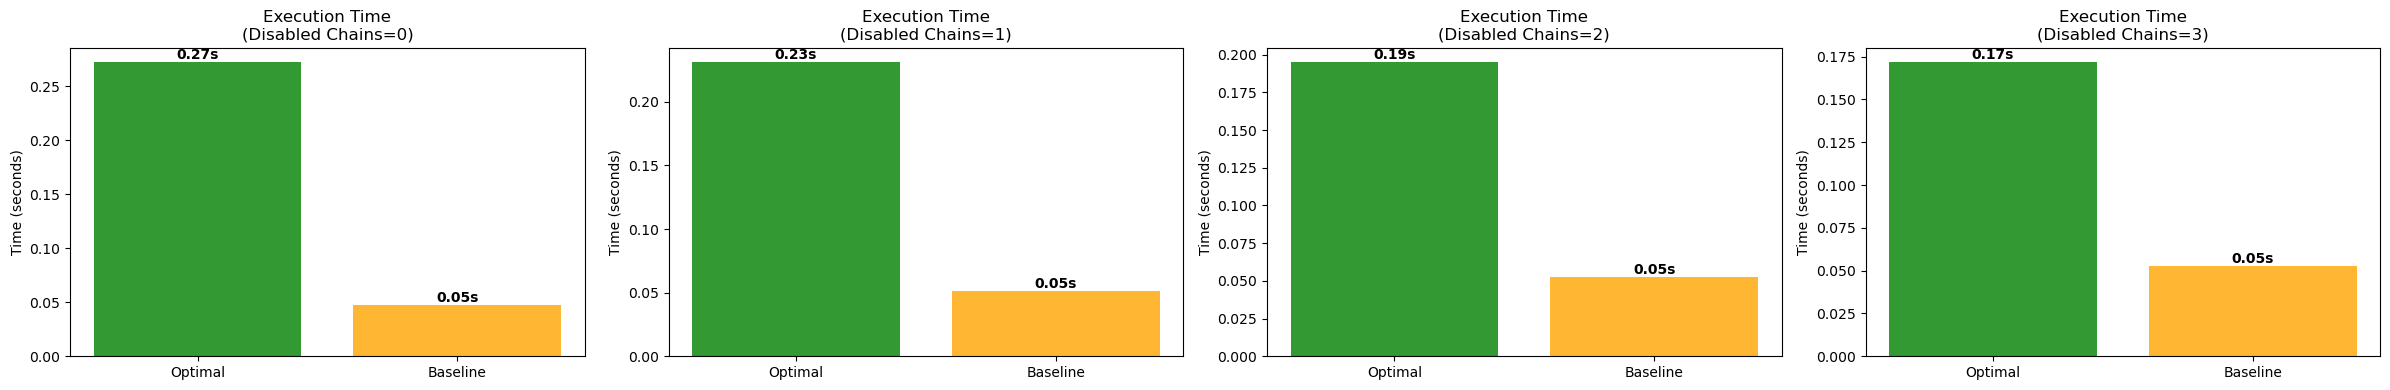

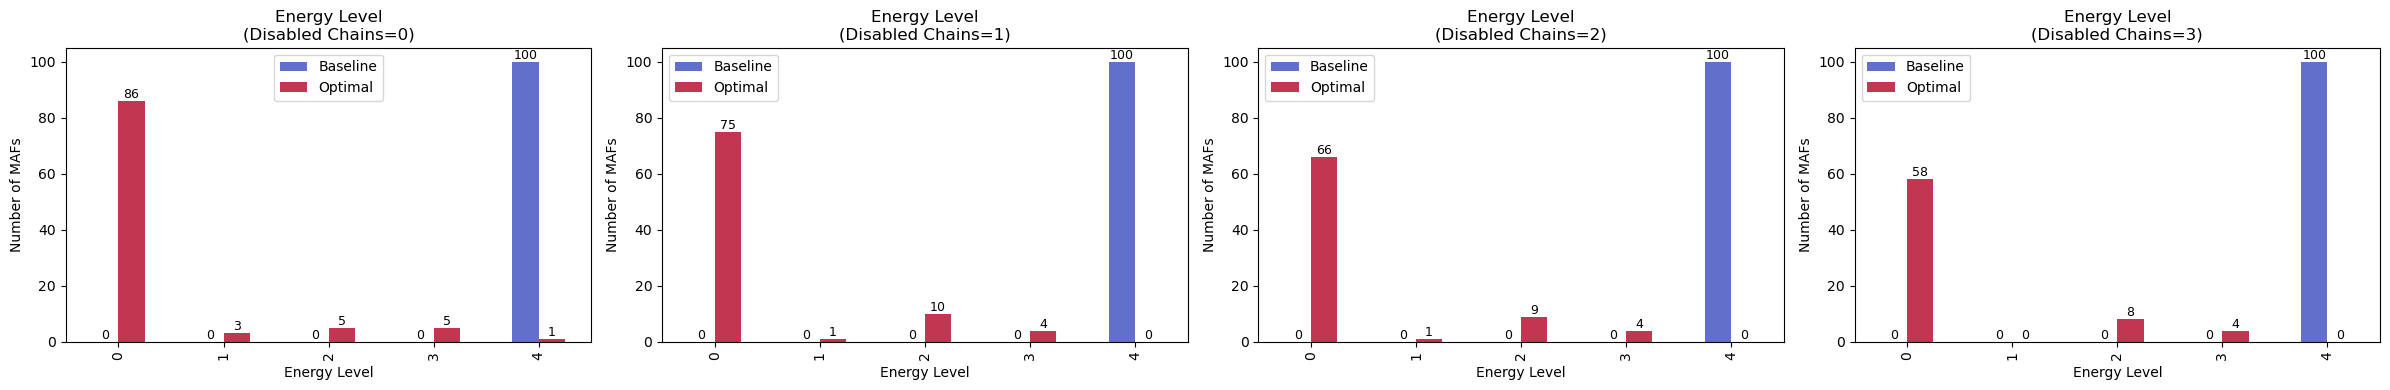

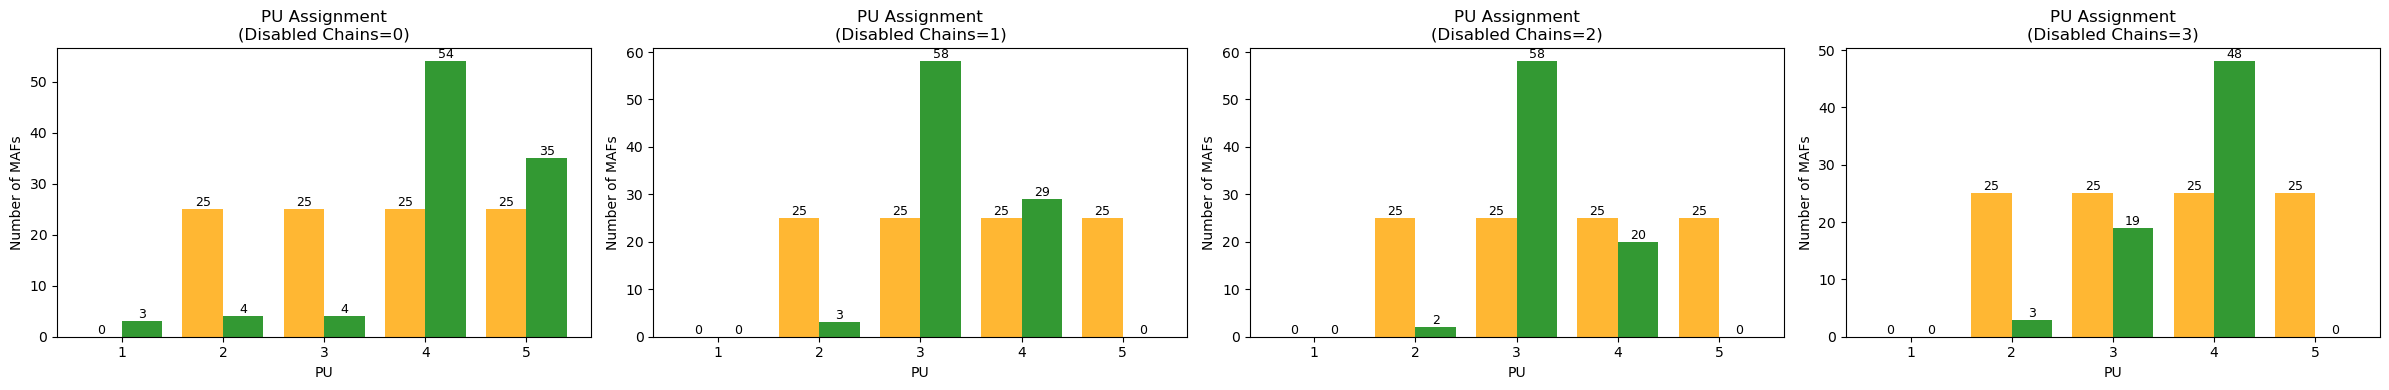

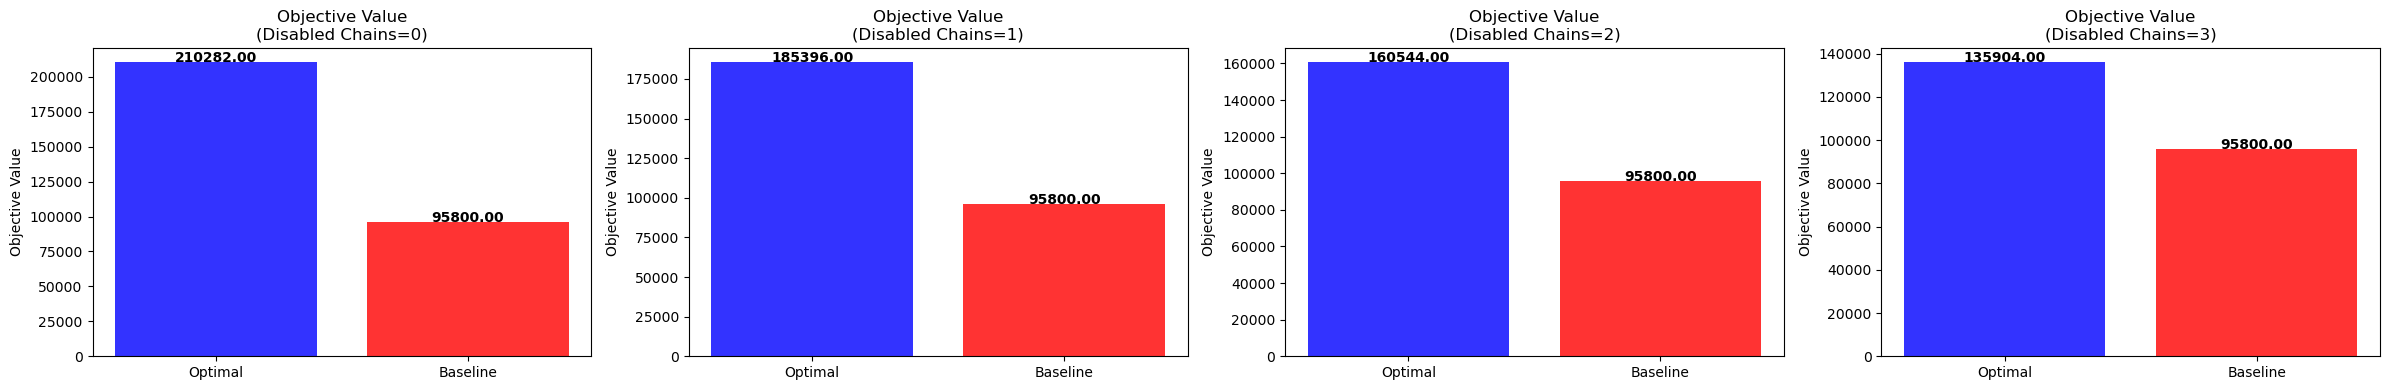

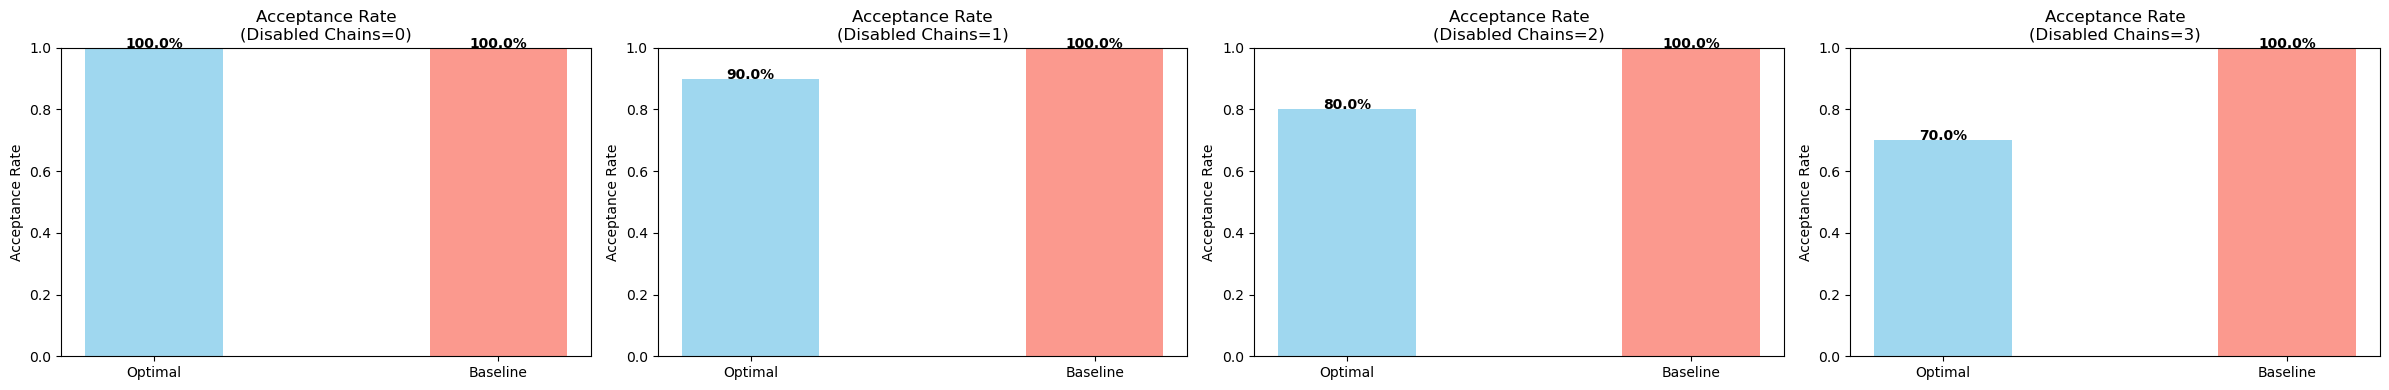

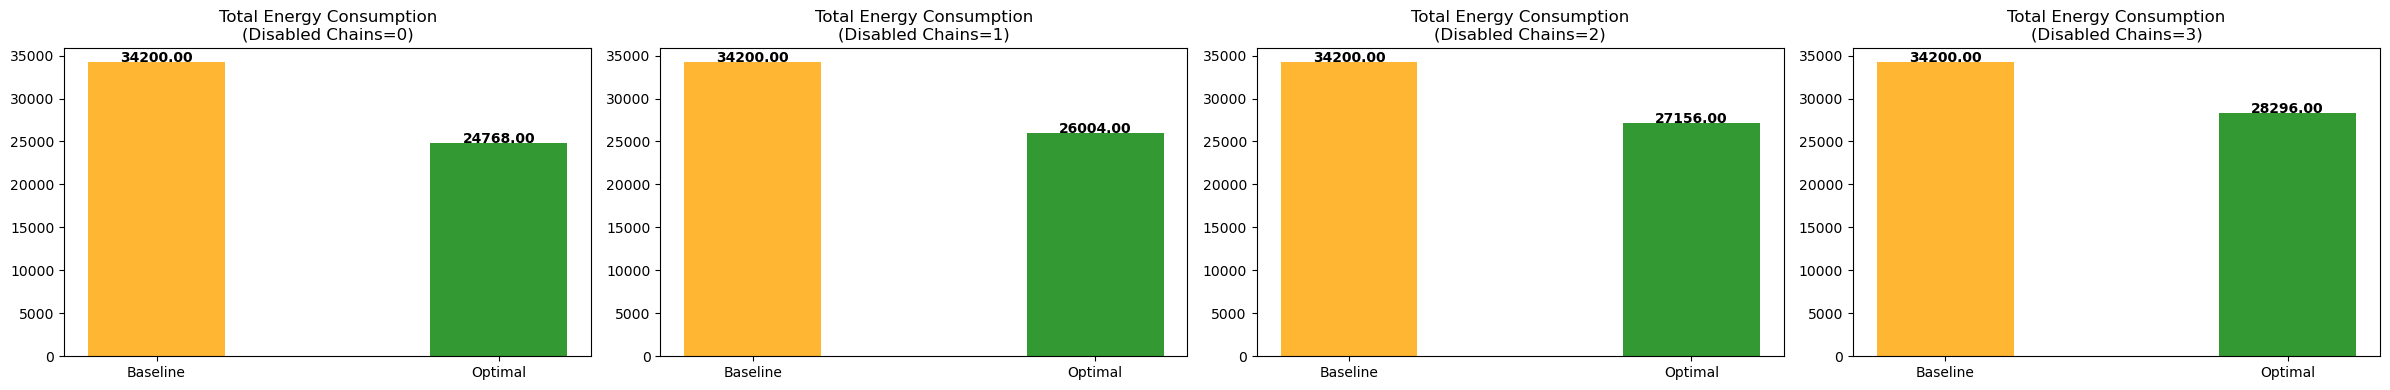

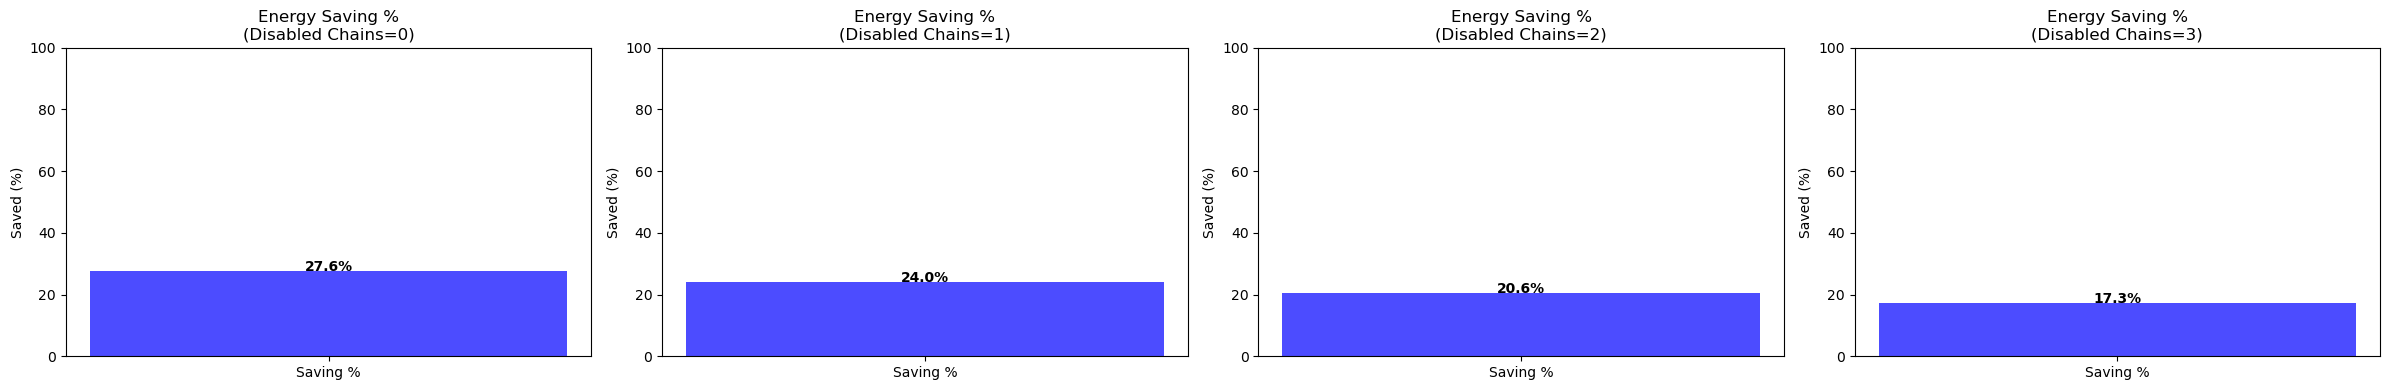

In [3]:
test_param_list = list(range(4))  # 禁用 0 ~ 5 条链
test_param_name = "Disabled Chains"

results = []

fig_time, axes_time = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_energy, axes_energy = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_pu, axes_pu = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_obj, axes_obj = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_accept, axes_accept = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_total_energy, axes_total_energy = plt.subplots(1, len(test_param_list), figsize=(24, 4))
fig_saving_pct, axes_saving_pct = plt.subplots(1, len(test_param_list), figsize=(24, 4))

for idx, param_value in enumerate(test_param_list):

    
    # 设置每次要禁用的链
    chain_enabled = {k: 0 if k < param_value else 1 for k in range(num_chains)}



    # Optimal 
    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(2500, 10, 1, baseline=False, chain_enabled=chain_enabled)
    execution_time_opt = time.perf_counter() - start_time_opt

    # Baseline
    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(2500, 10, 1, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base

    optimal_obj = optimal_model.objVal if optimal_model else None
    baseline_obj = baseline_model.objVal if baseline_model else None

    acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
    acceptance_rate_base = calculate_acceptance_rate(baseline_model)

    optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
    baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)

    results.append({
        test_param_name: param_value,
        'Optimal_Obj': optimal_obj,
        'Baseline_Obj': baseline_obj,
        'Optimal_Time': execution_time_opt,
        'Baseline_Time': execution_time_base,
        'Optimal_Acceptance': acceptance_rate_opt,
        'Baseline_Acceptance': acceptance_rate_base,
    })

    # === Execution Time ===
    axes_time[idx].bar(["Optimal", "Baseline"], [execution_time_opt, execution_time_base],
                       color=["green", "orange"], alpha=0.8)
    axes_time[idx].set_title(f"Execution Time\n({test_param_name}={param_value})")
    axes_time[idx].set_ylabel('Time (seconds)')
    for i, v in enumerate([execution_time_opt, execution_time_base]):
        axes_time[idx].text(i, v, f'{v:.2f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # === Energy Level ===
    df_energy = pd.DataFrame({
        "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
        "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
    })
    df_energy.plot(kind="bar", ax=axes_energy[idx], colormap="coolwarm", alpha=0.8)
    axes_energy[idx].set_title(f"Energy Level\n({test_param_name}={param_value})")
    axes_energy[idx].set_xlabel("Energy Level")
    axes_energy[idx].set_ylabel("Number of MAFs")

    # 🚩 添加数值标注
    for container in axes_energy[idx].containers:
        axes_energy[idx].bar_label(container, fontsize=9)


    # === PU Assignment ===
    df_pu = pd.DataFrame({
        "Baseline": np.bincount(baseline_pu_assignments, minlength=m + 1)[1:].astype(int),
        "Optimal": np.bincount(optimal_pu_assignments, minlength=m + 1)[1:].astype(int)
    })
    bar_width = 0.4
    x = np.arange(1, m + 1)

    bars_baseline = axes_pu[idx].bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", alpha=0.8, label="Baseline")
    bars_optimal = axes_pu[idx].bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", alpha=0.8, label="Optimal")

    axes_pu[idx].set_title(f"PU Assignment\n({test_param_name}={param_value})")
    axes_pu[idx].set_xlabel("PU")
    axes_pu[idx].set_ylabel("Number of MAFs")
    axes_pu[idx].set_xticks(np.arange(1, m + 1))

    # 🚩 添加数值标注
    axes_pu[idx].bar_label(bars_baseline, fontsize=9)
    axes_pu[idx].bar_label(bars_optimal, fontsize=9)

    
    # === Objective Value ===
    axes_obj[idx].bar(["Optimal", "Baseline"], [optimal_obj, baseline_obj], color=["blue", "red"], alpha=0.8)
    axes_obj[idx].set_title(f"Objective Value\n({test_param_name}={param_value})")
    axes_obj[idx].set_ylabel("Objective Value")
    for i, v in enumerate([optimal_obj, baseline_obj]):
        axes_obj[idx].text(i, v, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

    # === Acceptance Rate ===
    axes_accept[idx].bar(["Optimal", "Baseline"], [acceptance_rate_opt, acceptance_rate_base], color=["skyblue", "salmon"], alpha=0.8, width=0.4)
    axes_accept[idx].set_ylim(0, 1)
    axes_accept[idx].set_title(f"Acceptance Rate\n({test_param_name}={param_value})")
    axes_accept[idx].set_ylabel("Acceptance Rate")
    for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
        axes_accept[idx].text(i, v, f"{v:.1%}", ha='center', fontsize=10, fontweight='bold')

    _, baseline_total_energy = calculate_total_energy(baseline_model)
    _, optimal_total_energy = calculate_total_energy(optimal_model)


    # 绘制能耗柱状图
    axes_total_energy[idx].bar(
        ["Baseline", "Optimal"],
        [baseline_total_energy, optimal_total_energy],
        color=["orange", "green"],
        alpha=0.8,
        width=0.4
    )

    axes_total_energy[idx].set_title(f"Total Energy Consumption\n({test_param_name}={param_value})")

    # ✅ 去掉 Y 轴单位说明
    axes_total_energy[idx].set_ylabel("")

    # ✅ 添加数值标注（保留 2 位小数）
    for i, v in enumerate([baseline_total_energy, optimal_total_energy]):
        axes_total_energy[idx].text(i, v, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")


    if baseline_total_energy > 0:
        energy_saving_pct = (baseline_total_energy - optimal_total_energy) / baseline_total_energy
    else:
        energy_saving_pct = 0

    # 🌿 节能提升百分比图
    axes_saving_pct[idx].bar(["Saving %"], [energy_saving_pct * 100],
                            color="blue", alpha=0.7, width=0.4)

    axes_saving_pct[idx].set_ylim(0, 100)
    axes_saving_pct[idx].set_title(f"Energy Saving %\n({test_param_name}={param_value})")
    axes_saving_pct[idx].set_ylabel("Saved (%)")

    # 标注百分比数值
    axes_saving_pct[idx].text(0, energy_saving_pct * 100,
                            f"{energy_saving_pct * 100:.1f}%",
                            ha="center", fontsize=10, fontweight="bold")




fig_time.tight_layout()
fig_energy.tight_layout()
fig_pu.tight_layout()
fig_obj.tight_layout()
fig_accept.tight_layout()
fig_total_energy.tight_layout()
fig_saving_pct.tight_layout()
plt.show()